# Deep Ritz method and PINN for solving high-dimensional PDEs

Consider the Poisson equation
$$
\left\{
    \begin{aligned}
        - \Delta u &= -200, & & x \in \Omega \\
        u (x) &= \sum_{k} x_{k}^{2} & & x \in \partial \Omega
    \end{aligned}
\right.
$$
where $\Omega = (0, 1)^{100}$

## Import the necessary libs

In [1]:
#!-*- coding:utf-8 -*-
%matplotlib inline
import os
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float64)

## Define the neural network

In [2]:

class Act(nn.Module):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x):
        return torch.maximum(torch.pow(x, 3.0), torch.zeros_like(x))

class Block(nn.Module):
    def __init__(self, m:int) -> None:
        super().__init__()

        self.l1 = nn.Sequential(nn.Linear(m, m), Act())
        self.l2 = nn.Sequential(nn.Linear(m, m), Act())

    def forward(self, x):

        y = self.l1(x)
        y = self.l2(y)
        y = y + x

        return y

class Net(nn.Module):
    def __init__(self, d, m, n) -> None:
        super().__init__()
        
        # input transformation
        if d < m:
            pl = (m - d) // 2
            pr = m - d - pl
            self.input_transform = lambda x: nn.functional.pad(x, (pl, pr), "constant", 0)

        elif d > m:
            self.input_transform = nn.Linear(d, m)

        else:
            self.input_transform = nn.Identity()

        self.z = nn.ModuleList([Block(m) for _ in range(n)])

        self.last = nn.Linear(m, 1)

    def forward(self, x):

        z = self.input_transform(x)

        for m in self.z:
            z = m(z)
        
        out = self.last(z)

        return out

## Define Deep Ritz Method

In [3]:

class DeepRitz(nn.Module):
    def __init__(self, d, m, n, beta) -> None:
        super().__init__()

        self.beta = beta
        self.net = Net(d, m, n)

        print(f"num of parameters: {sum([p.numel() for p in self.net.parameters()])}")

    def train_problem(self, problem, steps, in_bs, bd_bs, lr, opt_type="adam", log_every=1000, save_every=1000, save_dir=None):

        # build the optimizer
        if opt_type == "sgd":
            opt = torch.optim.SGD(self.net.parameters(), lr=lr)
        elif opt_type == "adam":
            opt = torch.optim.Adam(self.net.parameters(), lr=lr, betas=(0.5, 0.999))
        else:
            raise ValueError

        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=opt, step_size=2 * steps // 5, gamma=0.2)

        # train loop
        for step in range(steps):
        
            opt.zero_grad()

            # inner conditions
            x_in = problem.sample_inner(in_bs)
            x_in = torch.from_numpy(x_in).requires_grad_(True)
            u_in = self.net(x_in)
            loss_in = problem.ritz_loss_inner(u_in, x_in)

            # boundary conditions
            x_bd = problem.sample_boundary(bd_bs)
            x_bd = torch.from_numpy(x_bd).requires_grad_(True)
            u_bd = self.net(x_bd)
            loss_bd = problem.ritz_loss_boundary(u_bd, x_bd)

            loss = loss_in.mean() + self.beta * loss_bd.mean()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(parameters=self.net.parameters(), max_norm=10, norm_type=2)

            opt.step()

            if (step + 1) % log_every == 0:
                print(f"[{step + 1:d}/{steps:d}]: total loss: {loss.item():.2f}, inner loss: {loss_in.mean().item():.2f}, boundary loss: {loss_bd.mean().item():.2f}")

            if save_dir is not None and (step + 1) % save_every == 0:
                torch.save(self.state_dict(), f"{save_dir}/step-{step + 1:d}.pth")
                # print(f"[{step + 1:d}/{steps:d}]: model saved to {save_dir}/step-{step + 1:d}.pth")

            lr_scheduler.step()


## Define the problem

In [4]:

class HighDimension_Problem(object):
    def __init__(self, dim=100) -> None:
        
        self.dim = dim

    def sample_inner(self, n, eps=1e-7):
        
        x = np.random.uniform(low=0 + eps, high=1 - eps, size=(n, self.dim))

        return x

    def sample_boundary(self, n, eps=1e-7):
        
        a = n // (2 * self.dim)
        x = np.random.uniform(low=0 + eps, high=1 - eps, size=(2 * self.dim * a, self.dim))
        for d in range(self.dim):
            x[(2 * d + 0) * a : (2 * d + 1) * a:, d] = 0.0
            x[(2 * d + 1) * a : (2 * d + 2) * a:, d] = 1.0

        return x

    def ritz_loss_inner(self, u, x):
        
        du = torch.autograd.grad(outputs=u[:, 0], inputs=x, 
                                 grad_outputs=torch.ones_like(u[:, 0]), 
                                 retain_graph=True, create_graph=True)[0]
        
        loss = torch.sum(torch.square(du), dim=1, keepdim=True) / 2 + 2 * self.dim * u
        
        return loss

    def ritz_loss_boundary(self, u, x):
        
        g = torch.sum(torch.square(x), dim=1)
        loss = torch.square(u - g)
        return loss

    def pinn_loss_inner(self, u, x):
        
        du = torch.autograd.grad(outputs=u[:, 0], inputs=x, 
                                 grad_outputs=torch.ones_like(u[:, 0]), 
                                 retain_graph=True, create_graph=True)[0]

        d2u = torch.zeros(x.size(0))
        for d in range(self.dim):
            d2u += torch.autograd.grad(outputs=du[:, d], inputs=x, 
                                       grad_outputs=torch.ones_like(du[:, d]), 
                                       retain_graph=True, create_graph=True)[0][:, d]

        loss = torch.square(-d2u.view(-1, 1) + 2 * self.dim * u)
        return loss

    def pinn_loss_boundary(self, u, x):

        g = torch.sum(torch.square(x), dim=1, keepdim=True)
        loss = torch.square(u - g)
        return loss

    def exact_sol(self, x):

        return torch.sum(torch.square(x), dim=1, keepdim=True)


## Define some utility functions and hyper-parameters

In [5]:
def set_seed(x):
    np.random.seed(x)
    torch.manual_seed(x)
    torch.cuda.manual_seed_all(x)
    torch.backends.cudnn.deterministic = True

torch.set_default_dtype(torch.float64)

set_seed(100)

# hyper-parameters
dim = 100
in_bs = 1000
bd_bs = 1000
lr = 1e-3
num_steps = 3000
log_every = 500
save_every = 200

## Create the problem

In [6]:

problem = HighDimension_Problem(dim=dim)


## Construct the deep ritz model and train

In [7]:

deepritz = DeepRitz(d=dim, m=100, n=3, beta=1000)


save_dir = "outputs/drm/hd"

if not os.path.exists(save_dir):
    os.makedirs(save_dir, exist_ok=True)

deepritz.train_problem(problem=problem, steps=num_steps, in_bs=in_bs, bd_bs=bd_bs, lr=lr, opt_type="adam", log_every=log_every, save_dir=save_dir, save_every=save_every)


num of parameters: 60701
[500/3000]: total loss: 129120.98, inner loss: 5095.68, boundary loss: 124.03
[1000/3000]: total loss: 62028.46, inner loss: 5601.74, boundary loss: 56.43
[1500/3000]: total loss: 23846.34, inner loss: 6524.88, boundary loss: 17.32
[2000/3000]: total loss: 19074.95, inner loss: 6542.76, boundary loss: 12.53
[2500/3000]: total loss: 17415.68, inner loss: 6658.42, boundary loss: 10.76
[3000/3000]: total loss: 17012.31, inner loss: 6627.65, boundary loss: 10.38


## Numerical results of error

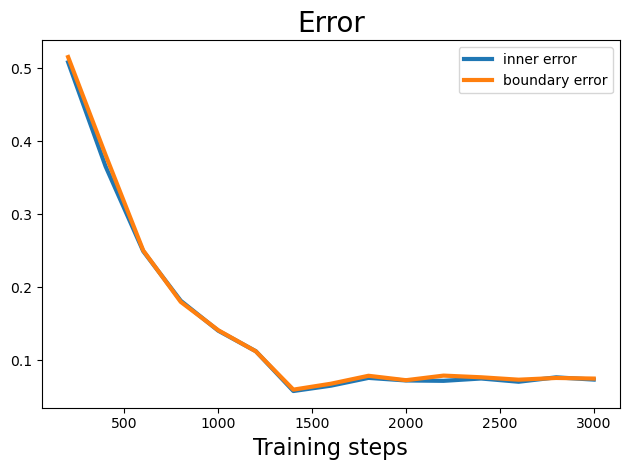

In [8]:

in_size = 1000
bd_size = 1000

deepritz.net.eval()

e_in = list()
e_bd = list()

for i in range(num_steps // save_every):

    step = (i + 1) * save_every

    model_ckpt = os.path.join(save_dir, f"step-{step}.pth")
    deepritz.load_state_dict(torch.load(model_ckpt))

    # inner conditions
    x_in = problem.sample_inner(in_size)
    x_in = torch.from_numpy(x_in)
    u_in = deepritz.net(x_in).detach().numpy()
    u_in_e = problem.exact_sol(x_in).detach().numpy()
    e = (np.abs(u_in_e - u_in) / np.abs(u_in)).mean()
    e_in.append(e)

    # boundary conditions
    x_bd = problem.sample_boundary(bd_size)
    x_bd = torch.from_numpy(x_bd)
    u_bd = deepritz.net(x_bd).detach().numpy()
    u_bd_e = problem.exact_sol(x_bd).detach().numpy()
    e = (np.abs(u_bd_e - u_bd) / np.abs(u_bd)).mean()
    e_bd.append(e)
    

fig, ax = plt.subplots()
fig.set_tight_layout(True)

x = np.linspace(start=save_every, stop=num_steps, num=num_steps // save_every, endpoint=True)
ax.plot(x, e_in, label="inner error", lw=3)
ax.plot(x, e_bd, label="boundary error", lw=3)

ax.set_title("Error", fontsize=20)
ax.set_xlabel("Training steps", fontsize=16)
ax.legend(loc="upper right")

fig.show()
